In [ ]:
# Cell Nuclei Separation using Marker-Controlled Watershed

Objective: Separate touching nuclei using:

- Watershed without markers
- Marker-controlled watershed

Dataset: 2018 Data Science Bowl (Kaggle Competition)

Evaluation:
- Number of segmented regions
- Visual comparison of over-segmentation

In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [34]:
BASE_PATH = "/kaggle/working"   

for folder in os.listdir(BASE_PATH):
    if folder.startswith("."):
        continue
    sample_path = os.path.join(BASE_PATH, folder)
    if os.path.isdir(sample_path):
        break

image_path = os.path.join(sample_path, "images",
                          os.listdir(os.path.join(sample_path, "images"))[0])

mask_dir = os.path.join(sample_path, "masks")

image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print("Loaded sample:", sample_path)

Loaded sample: /kaggle/working/237802ac5005f9cf782367156c46c383efd9e05088e5768ca883cbbe24abadb1


In [35]:
# Otsu threshold
_, thresh = cv2.threshold(gray, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Remove noise
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

In [36]:
# weak foreground threshold
_, sure_fg1 = cv2.threshold(dist_transform,
                            0.4 * dist_transform.max(),
                            255, 0)

sure_fg1 = np.uint8(sure_fg1)
unknown1 = cv2.subtract(sure_bg, sure_fg1)

_, markers1 = cv2.connectedComponents(sure_fg1)
markers1 = markers1 + 1
markers1[unknown1 == 255] = 0

markers1 = cv2.watershed(image.copy(), markers1)

result_without = image.copy()
result_without[markers1 == -1] = [255,0,0]   # red boundary

print("Regions (without control):",
      len(np.unique(markers1)) - 1)

Regions (without control): 9


In [37]:
# stronger foreground threshold
_, sure_fg2 = cv2.threshold(dist_transform,
                            0.6 * dist_transform.max(),
                            255, 0)

sure_fg2 = np.uint8(sure_fg2)
unknown2 = cv2.subtract(sure_bg, sure_fg2)

_, markers2 = cv2.connectedComponents(sure_fg2)
markers2 = markers2 + 1
markers2[unknown2 == 255] = 0

markers2 = cv2.watershed(image.copy(), markers2)

result_with = image.copy()
result_with[markers2 == -1] = [0,255,0]   # green boundary

print("Regions (with marker control):",
      len(np.unique(markers2)) - 1)

Regions (with marker control): 8


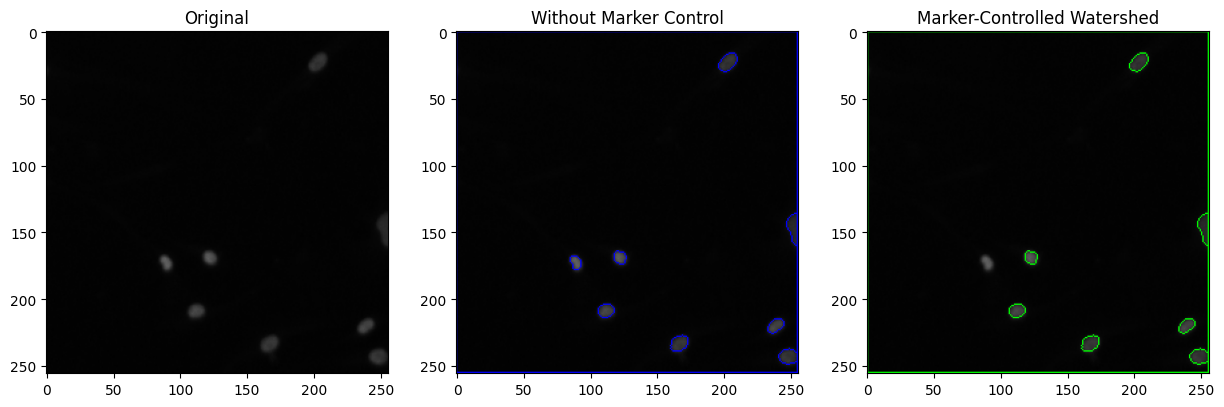

In [38]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(result_without, cv2.COLOR_BGR2RGB))
plt.title("Without Marker Control")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(result_with, cv2.COLOR_BGR2RGB))
plt.title("Marker-Controlled Watershed")

plt.show()

In [ ]:
## Conclusion

    Watershed without proper markers produces over-segmentation.
    
    Marker-controlled watershed reduces false splits.
    
    Distance transform improves separation of touching nuclei.
    
    Proper foreground selection controls region boundaries.